In [2]:
from __future__ import division

import cv2
import numpy as np

import matplotlib.pylab as plt 
%matplotlib inline

import os
import random
import math
import sys

from scipy.linalg import block_diag

In [7]:
%matplotlib inline

In [4]:
path = '../New DATASET/Day Imgs/'
files = os.listdir(path)
img = 'day24000.jpg'

In [1]:
class SpecularityRemoval(object):
    
    def __init__(self, image, saturation_value):
        """
        param: image: str;
        path+image_file_name
        
        param: saturation: int;
        below this all pixels that are not very saturated 
        """
        self.image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB);
        self.saturation_value = saturation_value
        self.index = 1
        self.disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        
    def hsv_split(self, img):
        h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
        return h,s,v
    
    def brightness_mask(self, saturation, value):
        """
        param saturation: array;
        saturation of hsv
        
        param value: array
        value of hsv
        """
        nonSat = saturation < self.saturation_value # Find all pixels that are not very saturated

        # Slightly decrease the area of the non-satuared pixels by a erosion operation.
        
        nonSat = cv2.erode(nonSat.astype(np.uint8), self.disk)

        # Set all brightness values, where the pixels are still saturated to 0.
        v2 = value.copy()
        v2[nonSat == 0] = 0
        
        return v2
    
    def glared_mask(self, brightness_mask):
        glare = brightness_mask > 200  # filter out very bright pixels.
        # Slightly increase the area for each pixel
        glare = cv2.dilate(glare.astype(np.uint8), self.disk);  
        glare = cv2.dilate(glare.astype(np.uint8), self.disk);
        return glare
    
    def corrected_image(self):
        h,s,v = self.hsv_split(self.image)
        brightness = self.brightness_mask(s,v)
        glare = self.glared_mask(brightness)
    
        return cv2.inpaint(self.image, glare, 5, cv2.INPAINT_NS)
    
    def plot(self, image, name, gray=False):
        plt.imshow(image, cmap='gray')
        plt.title(name)
        plt.show()
        
    def subplots(self, rows, cols, plots, titles, figsize, output_dir, save=False):
        num = 0
        figure, axes = plt.subplots(rows, cols, figsize=figsize)
        if len(plots) == len(titles):
            if rows * cols == len(plots):
                if rows == 1:
                    for j in range(cols):
                        ax = axes[j]
                        ax.imshow(plots[num])
                        ax.set_title(titles[num])
                        num+=1
                elif cols == 1:
                    for i in range(rows):
                        ax = axes[i]
                        ax.imshow(plots[num])
                        ax.set_title(titles[num])
                        num+=1
                else:
                    for i in range(rows):
                        for j in range(cols):
                            ax = axes[i][j]
                            ax.imshow(plots[num])
                            ax.set_title(titles[num])
                            num+=1
                
                if save:
                    file_name = 'specularity_removal'
                    img_path = os.path.join(output_dir, file_name+str(self.index)+'.jpg')
                    plt.savefig(img_path)
                    self.index += 1
                    
                plt.show()
            else:
                raise "rows * cols must be equal to len(titles) & len(plots)"
        else:
            raise "len(plots) must be equals to len(titles)"
        return None
            

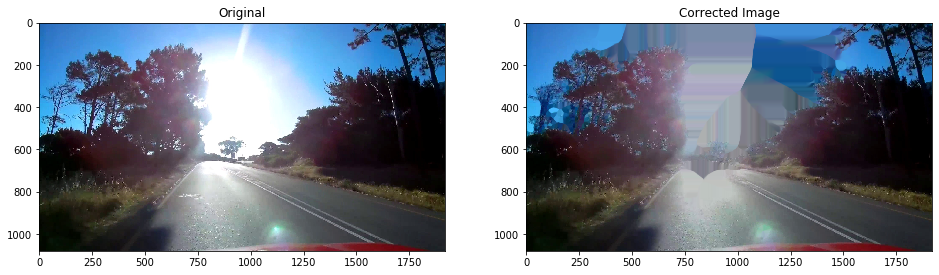

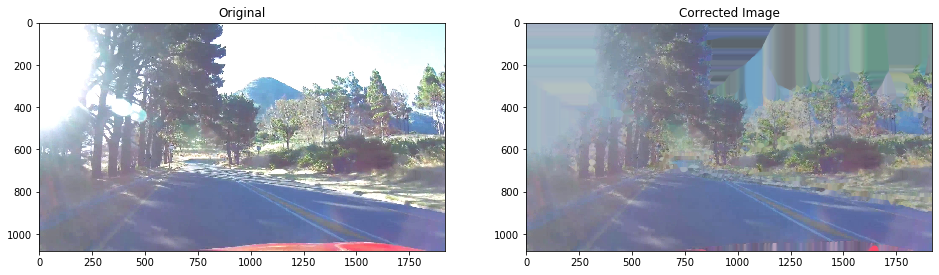

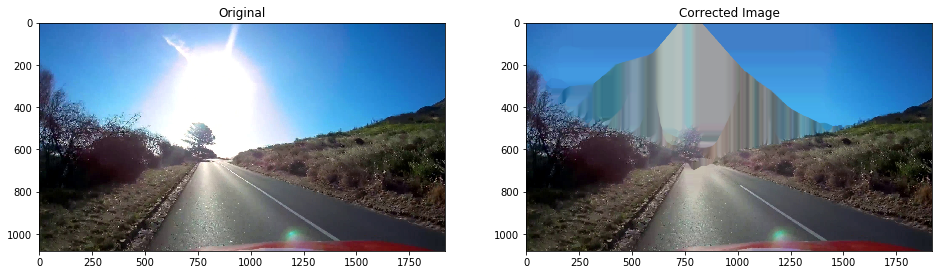

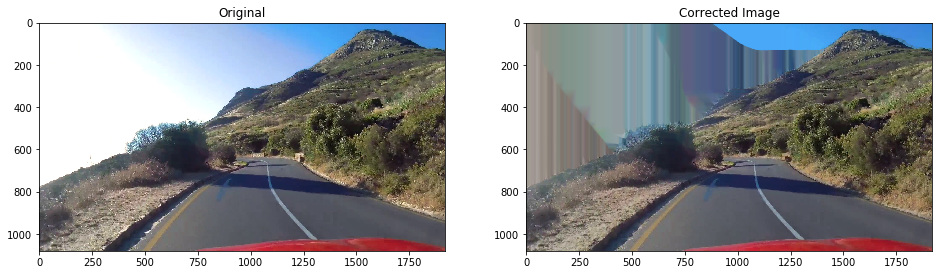

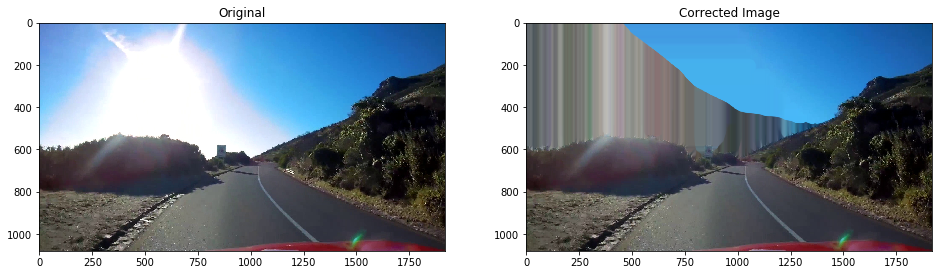

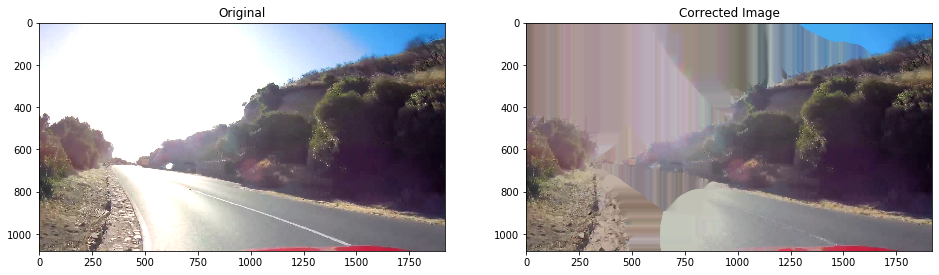

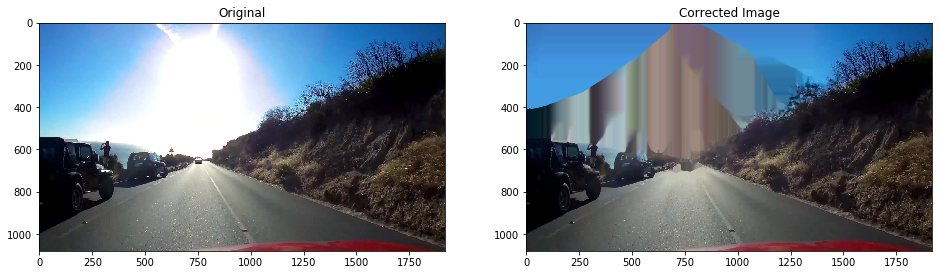

In [105]:
g_path = '../New DATASET/Glare/'
g_files = os.listdir(g_path)
num = 1
for img in g_files:
    sr = SpecularityRemoval(os.path.join(g_path, img), 180)
    sr.index = num
    corr = sr.corrected_image()
    sr.subplots(1, 2, [sr.image, corr], ['Original', 'Corrected Image'], (16,5), '../New DATASET/SpecularityRemoval/', save=True)
    num += 1